# This Notebook presents an expriment of Theory Of Mind on Schelling Coordination Game

In [28]:
# Import libraries.
using Turing, StatsPlots, Random, Plots, Memoization


In [27]:
import Pkg; Pkg.add("Memoization")

   Updating registry at `C:\Users\tomer\.julia\registries\General`
  Resolving package versions...
  Installed IntelOpenMP_jll ─ v2018.0.3+2
  Installed libsodium_jll ─── v1.0.18+1
  Installed ZeroMQ_jll ────── v4.3.2+6
Updating `C:\Users\tomer\.julia\environments\v1.5\Project.toml`
  [6fafb56a] + Memoization v0.1.5
Updating `C:\Users\tomer\.julia\environments\v1.5\Manifest.toml`
  [1d5cc7b8] ↑ IntelOpenMP_jll v2018.0.3+0 ⇒ v2018.0.3+2
  [6fafb56a] + Memoization v0.1.5
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+5 ⇒ v4.3.2+6
  [a9144af2] + libsodium_jll v1.0.18+1


We have 2 players: Bob and Alice.
They Want to arrive to the same point. they can't communicate, they only can infernce about each other.
We will model it using PPL. And use Practicle Gibbs Sampling.

In [22]:
Random.rand([1,2,4343, 4343  , 1123])

2

In [23]:
function get_random_sample(samples)
    return Random.rand(samples)
end

get_random_sample (generic function with 1 method)

In [2]:
function get_most_common_sample(samples)
    count = zeros(2)
    for i in 1:length(samples)
        sample = round(Int64, samples[i] + 1) 
        count[sample] += 1 
    end
    if count[1] > count[2]
        return 0
    else
        return 1
    end
end

get_most_common_sample (generic function with 1 method)

In [29]:
@memoize memoized_sample(args...) = sample(args...)

memoized_sample (generic function with 1 method)

In [16]:
function get_location(samples)
#     return samples[:my_location][end]
    return get_random_sample(samples[:my_location])
end

get_location (generic function with 1 method)

In [4]:
@model function location_prior(popularity=0.55)
    popular_bar ~ Bernoulli(popularity)
    return popular_bar
end

location_prior (generic function with 2 methods)

In [5]:
@model function bob(depth = 0, popularity=0.55)
    my_location ~ Bernoulli(popularity)
    return round(Int64, my_location)
end

bob (generic function with 3 methods)

In [32]:
@model function alice(other_person_place, popularity = 0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    other_location = get_location(memoized_sample(other_person_place(), IS(), 3000))
    other_location ~ Dirac(my_location)
    return round(Int64, my_location)
end

alice (generic function with 3 methods)

In [33]:
samples = memoized_sample(alice(bob), IS(), 3000)

Chains MCMC chain (3000×3×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:3000
Thinning interval = 1
Chains            = 1
Samples per chain = 3000
parameters        = my_location, other_location
internals         = lp

Summary Statistics
      parameters      mean       std   naive_se      mcse         ess      rha ⋯
          Symbol   Float64   Float64    Float64   Float64     Float64   Float6 ⋯

     my_location    0.5500    0.4976     0.0091    0.0088   2893.4928    0.999 ⋯
  other_location    0.5500    0.4976     0.0091    0.0088   2893.4928    0.999 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

     my_location    0.0000    0.0000    1.0000    1.0000    1.0000
  other_location    0.0000    0.0000    1.0000    1.0000    1.0000


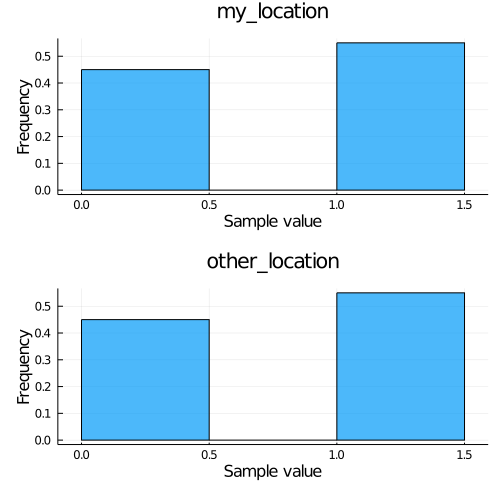

In [34]:
histogram(samples, bins = 2, normalize=:probability)

In [42]:
@model function alice_2(other_person_place, popularity = 0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    samples = memoized_sample(other_person_place(alice_2, popularity, depth -1), IS(), 10000)
    other_location = get_location(samples)
    other_location ~ Dirac(my_location)
    return my_location
end

alice_2 (generic function with 3 methods)

In [43]:
@model function bob_2(other_person_place, popularity=0.55, depth = 0)
    my_location ~ Bernoulli(popularity)
    if depth == 0
       return my_location 
    else
        other_location = get_location(memoized_sample(other_person_place(bob_2, popularity, depth), IS(), 10000))
        other_location ~ Dirac(my_location)
        return my_location
    end
end

bob_2 (generic function with 3 methods)

3, 30 , 30 - 6.5 hours

In [46]:
@time begin
    result = memoized_sample(alice_2(bob_2, 0.55, 20), IS(), 10000)
end

 23.672857 seconds (52.68 M allocations: 18.271 GiB, 16.48% gc time)


Chains MCMC chain (10000×3×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = my_location, other_location
internals         = lp

Summary Statistics
      parameters      mean       std   naive_se      mcse         ess      rha ⋯
          Symbol   Float64   Float64    Float64   Float64     Float64   Float6 ⋯

     my_location    0.5534    0.4972     0.0050    0.0050   9556.7728    1.000 ⋯
  other_location    0.5534    0.4972     0.0050    0.0050   9556.7728    1.000 ⋯
                                                                1 column omitted

Quantiles
      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

     my_location    0.0000    0.0000    1.0000    1.0000    1.0000
  other_location    0.0000    0.0000    1.0000    1.0000    1.0000


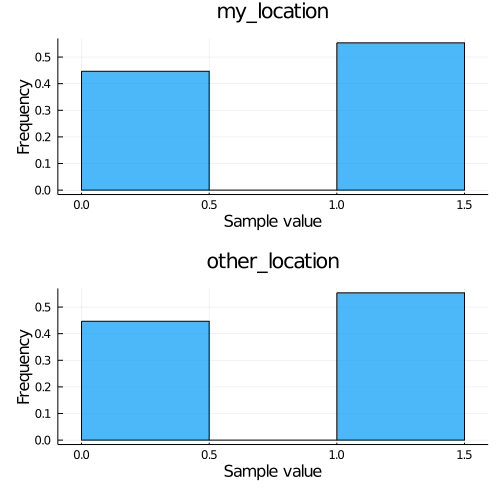

In [47]:
histogram(result, bins = 2, normalize=:probability)

4, 10, 10, 10